**Recall**
- AR alone: accounts for past values but takes time to account for past errors
- MA alone: accounts for past errors but does not have a baseline value from which to model errors
- ARMA = accounts for both past values and past errors

In [45]:
#modules and packages
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats.distributions import chi2
BOLD = '\033[1m'
END = '\033[0m'

In [82]:
#methods for LLR test
def LLR_Test(mod_1, mod_2, DF=1):
    res1 = mod_1.fit()
    res2 = mod_2.fit()
    res1.summary()
    LR = 2*(res2.llf - res1.llf)
    val = 'P-Value for LLR: ' + str(chi2.sf(LR, DF).round(3))
    return val
    
def LLR_Test_ARMA(mod_1, mod_2, DF=1):
    res1 = mod_1.fit()
    res2 = mod_2.fit()
    LR = 2*(res2.llf - res1.llf)
    print('P-Value for LLR: ' + str(chi2.sf(LR, DF).round(3)))
    print('**Results Summary for Lower Order Model**')
    return res1.summary()

#None nested ARMA model test
def LLR_ARMA_Nonest(mod_1, mod_2, DF=1, lags=None):
    res1 = mod_1.fit(start_ar_lags=lags)
    res2 = mod_2.fit(start_ar_lags=lags)
    print('Higher Order Model Measures:')
    print('LL =', res2.llf, '\tAIC =', res2.aic)
    print('Lower Order Model Measures:')
    print('LL =', res1.llf, '\tAIC =', res1.aic)
    if res1.llf > res2.llf and res1.aic < res2.aic:
        print(BOLD+'Lower order model > Higher order model'+END)
    if res2.llf > res1.llf and res2.aic < res1.aic:
        print(BOLD+'Higher order model > Lower order model'+END)

#method for displaying ACF and PCF
def ACF_and_PACF(series, title):
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,6))
    sgt.plot_acf(series, lags = 40, zero=False, ax=ax1)
    sgt.plot_pacf(series, lags = 40, zero=False, method = 'ols', ax=ax2)
    ax1.title.set_text('ACF Plot for ' + title)
    ax1.title.set_size(20)
    ax2.title.set_size(20)
    ax2.title.set_text('PACF Plot for ' + title)
    plt.show()

In [3]:
#add and prepare dataset
raw = pd.read_csv('Index2018.csv')
data = raw.copy()

#date as index and set frequency
data.date = pd.to_datetime(data.date, dayfirst=True)
data.set_index('date', inplace=True)
data = data.asfreq('b')
data = data.fillna(method = 'ffill')

#we are isolating FTSE to use and create additional columns
data['market_value'] = data.ftse
del data['ftse'], data['spx'], data['dax'], data['nikkei']
data['returns'] = data.market_value.pct_change(1).mul(100)
#benchmark = data.returns.iloc[1]
#data['norm_ret'] = data.returns.div(benchmark).mul(100)

#split into train and test
size = int(len(data)*0.8)
train = data.iloc[:size]
test = data.iloc[size:]

## ARMA Models - Stationary Data (Returns)
### Simple ARMA(1,1) Model
We will be using returns for this exercise since this is a stationary series based on ADF test earlier. 

In [4]:
model_ret_ar1_ma1 = ARMA(train.returns[1:], order=(1,1))
results_ret_ar1_ma1 = model_ret_ar1_ma1.fit()
results_ret_ar1_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 1)   Log Likelihood               -7916.500
Method:                       css-mle   S.D. of innovations              1.171
Date:                Thu, 09 Apr 2020   AIC                          15841.000
Time:                        11:09:02   BIC                          15867.085
Sample:                    01-10-1994   HQIC                         15850.140
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.446      0.148      -0.007       0.045
ar.L1.returns     0.7649      0.067     11.349      0.000       0.633       0.897
ma.L1.returns    -0.8141      0.061    -13.406      0.000      -0.933      -0.695
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3074           +0.0000j            1.3074            0.0000
MA.1            1.2284           +0.0000j            1.2284            0.0000
-----------------------------------------------------------------------------
"""

We can use the LLR test to see if the ARMA(1,1) is better than using just AR(1) or MA(1) models.

In [5]:
model_ret_ar1_ma1 = ARMA(train.returns[1:], order=(1,1))
model_ret_ar1 = ARMA(train.returns[1:], order=(1,0))
model_ret_ma1 = ARMA(train.returns[1:], order=(0,1))

In [6]:
print('ARMA vs AR', LLR_Test(model_ret_ar1, model_ret_ar1_ma1))
print('ARMA vs MA', LLR_Test(model_ret_ma1, model_ret_ar1_ma1))

ARMA vs AR P-Value for LLR: 0.0
ARMA vs MA P-Value for LLR: 0.0


We see that both cases: ARMA model is better. So next we try to see if higher order ARMA models fit the data better than the ARMA(1,1). Also note, **the order of AR and MA components does not have to be the same, but it could be.**

### Higher Order ARMA Models
Where as we add lags to see if our models improve for AR and MA models, in ARMA models the combination intends to reduce number of lag estimators included because we are now accounting for both past values and past errors. It would not take the AR model as much time to adjust to the previous season errors, and the MA model has a baseline with which to work. Given this, with ARMA models, we start from the higher over-parametrized models and move down to find our optimal solution (high log likelihood, low information criteria, all coefficients are significant).

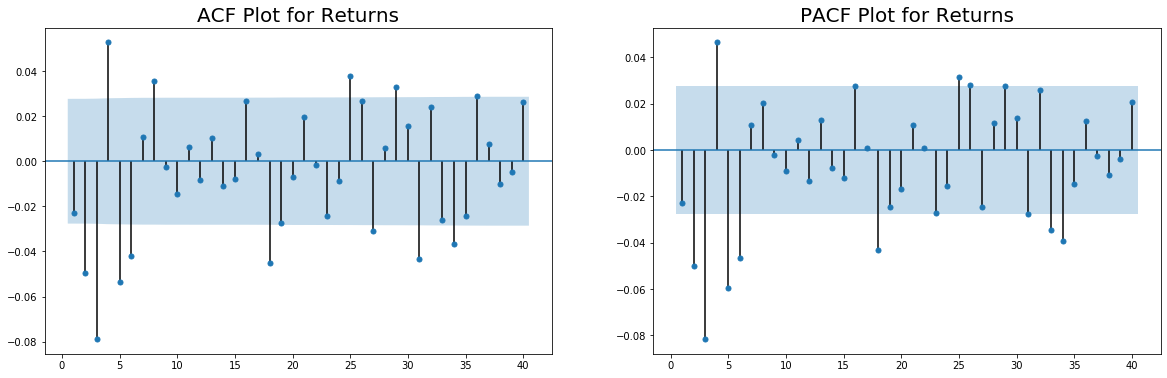

In [7]:
ACF_and_PACF(train.returns[1:], 'Returns')

Notice that we knew the best representations for models based on lag significance were AR(6) from the PACF and MA(8) from the ACF graphs. However if we use the values and try fitting an ARMA(6,8), it is a tedious long process. We can make this a little easier by noting that about half the lags were not significant for both figures. Therefore we can cut the number of lag orders by half to ARMA(3,4). Even better, we can make a business decision to do ARMA(3,3) by prioritizing the number of AR lags so lets start with that and see if we can improve an ARMA(3,3) model.

In [8]:
model_ret_ar1_ma1= ARMA(train.returns[1:], order=(1,1))
model_ret_ar3_ma3= ARMA(train.returns[1:], order=(3,3))
LLR_Test(model_ret_ar1_ma1, model_ret_ar3_ma3, DF = 4)

'P-Value for LLR: 0.0'

In [9]:
model_ret_ar3_ma3.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 3)   Log Likelihood               -7893.515
Method:                       css-mle   S.D. of innovations              1.166
Date:                Thu, 09 Apr 2020   AIC                          15803.030
Time:                        11:09:25   BIC                          15855.199
Sample:                    01-10-1994   HQIC                         15821.310
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.395      0.163      -0.008       0.045
ar.L1.returns    -0.1898      0.104     -1.827      0.068      -0.393       0.014
ar.L2.returns    -0.2942      0.087     -3.389      0.001      -0.464      -0.124
ar.L3.returns     0.4459      0.138      3.225      0.001       0.175       0.717
ma.L1.returns     0.1707      0.099      1.726      0.084      -0.023       0.365
ma.L2.returns     0.2277      0.084      2.701      0.007       0.062       0.393
ma.L3.returns    -0.5432      0.127     -4.270      0.000      -0.793      -0.294
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5168           -1.0283j            1.1508           -0.3241
AR.2           -0.5168           +1.0283j            1.1508            0.3241
AR.3            1.6932           -0.0000j            1.6932           -0.0000
MA.1           -0.5286           -0.9835j            1.1166           -0.3285
MA.2           -0.5286           +0.9835j            1.1166            0.3285
MA.3            1.4764           -0.0000j            1.4764           -0.0000
-----------------------------------------------------------------------------
"""

Based on the p-value we know the following:-
- A higher order model is better than the ARMA(1,1) because p < 0.05
- The better higher order model is somewhere between ARMA(1,1) and ARMA(3,3) because there are some coefficients in the bigger model that are not significant so we reduce the number of total orders until we get the optimal one.

To test the other variations, we keep reducing the number of total orders. In ARMA(3,3) -> 6 total orders. So the next model would have to have 5 total lags. So we can try ARMA(3,2) and ARMA(2,3).

**Model Interpretation**  
- All the ARMA components are significant. The constant isnt, but that is to be expected because it says that the returns on average (expected value) are not significantly different than zero -> they are zero; which is what we want to have in a market because adjustments happen to even things out.
- ARMA coefficients decrease in magnitude the further out the lags are. This makes sense since we expect that the older the period, the lesser effect it would have on today's returns
- **MA coefficients are positive:** This is to be expected. Suppose the predicted value for returns is greater than the actual value. Then the residual is negative. When multiplied by the coefficient, this number is negative and when this moving average is added to the predicted value, it helps us reduce this value to bring it closer to the actual value. Vice versa as well: if predicted < actual, then residual > 0, then residual x coefficient > 0. When this product is added to the predicted value, it helps bring it up closer to the actual value 
- **AR coefficients are negative:** explain here


**TEST THE REST OF THE MODELS**   
Remember = if p <= 0.05, higher order model is better  
Compare these to ARMA(3,3) and then to each other  
- ARMA(2,3)
- ARMA(2,2)
- ARMA(3,1)
- ARMA(1,3)
- ARMA(2,1)
- ARMA(1,2)

**Model Comparisons**  
Usually, we compare two models with the LLR test with just AR or MA models. With ARMA models, we only do this for models that are nested.

For two models ARMA(p1, q1) and ARMA(p2, q2) -> lower order model, ARMA(p2, q2) is considered to be nested if and only if:
- p1 + q1 > p2 + q2
- p1 >= p2
- q1 >= q2

In [53]:
#ARMA(3,2) versus ARMA(3,3)
#ARMA(3,2)
model_ret_ar3_ma2= ARMA(train.returns[1:], order=(3,2))
LLR_Test_ARMA(model_ret_ar3_ma2, model_ret_ar3_ma3)

P-Value for LLR: 0.035
**Results Summary for Lower Order Model**


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 2)   Log Likelihood               -7895.747
Method:                       css-mle   S.D. of innovations              1.166
Date:                Thu, 09 Apr 2020   AIC                          15805.495
Time:                        13:58:58   BIC                          15851.143
Sample:                    01-10-1994   HQIC                         15821.491
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.251      0.211      -0.011       0.048
ar.L1.returns    -0.6785      0.087     -7.799      0.000      -0.849      -0.508
ar.L2.returns    -0.5088      0.139     -3.670      0.000      -0.780      -0.237
ar.L3.returns    -0.1141      0.015     -7.655      0.000      -0.143      -0.085
ma.L1.returns     0.6568      0.087      7.536      0.000       0.486       0.828
ma.L2.returns     0.4474      0.141      3.175      0.001       0.171       0.724
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4929           -1.5101j            1.5885           -0.3002
AR.2           -0.4929           +1.5101j            1.5885            0.3002
AR.3           -3.4748           -0.0000j            3.4748           -0.5000
MA.1           -0.7340           -1.3025j            1.4951           -0.3317
MA.2           -0.7340           +1.3025j            1.4951            0.3317
-----------------------------------------------------------------------------
"""

In [13]:
#ARMA(2,3) versus ARMA(3,3)
model_ret_ar2_ma3= ARMA(train.returns[1:], order=(2,3))
LLR_Test_ARMA(model_ret_ar2_ma3, model_ret_ar3_ma3)

P-Value for LLR: 0.042
**Results Summary for Lower Order Model**


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 3)   Log Likelihood               -7895.587
Method:                       css-mle   S.D. of innovations              1.166
Date:                Thu, 09 Apr 2020   AIC                          15805.174
Time:                        11:12:51   BIC                          15850.823
Sample:                    01-10-1994   HQIC                         15821.170
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.015      1.276      0.202      -0.010       0.048
ar.L1.returns    -0.5605      0.090     -6.245      0.000      -0.736      -0.385
ar.L2.returns    -0.4187      0.193     -2.172      0.030      -0.797      -0.041
ma.L1.returns     0.5378      0.090      6.000      0.000       0.362       0.714
ma.L2.returns     0.3540      0.195      1.818      0.069      -0.028       0.736
ma.L3.returns    -0.1158      0.016     -7.369      0.000      -0.147      -0.085
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.6694           -1.3930j            1.5455           -0.3213
AR.2           -0.6694           +1.3930j            1.5455            0.3213
MA.1           -0.7270           -1.1772j            1.3836           -0.3381
MA.2           -0.7270           +1.1772j            1.3836            0.3381
MA.3            4.5096           -0.0000j            4.5096           -0.0000
-----------------------------------------------------------------------------
"""

**Five order model comparisons**   
ARMA(2,3) is out of contention because it has insignificant coefficients. Even though the LLR test says that ARMA(3,3) is better than ARMA(3,2), the ARMA(3,3) has insignificant coefficients at 5% level. Therefore, **we favor the lower order model because it gives a good result (ARMA coefficients are significant) so we compare anything moving forward to the ARMA(3,2)**

In [49]:
#ARMA(3,1) versus ARMA(3,2)
model_ret_ar3_ma1= ARMA(train.returns[1:], order=(3,1))
LLR_Test_ARMA(model_ret_ar3_ma1, model_ret_ar3_ma2)

P-Value for LLR: 0.01
**Results Summary for Lower Order Model**


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 1)   Log Likelihood               -7899.072
Method:                       css-mle   S.D. of innovations              1.167
Date:                Thu, 09 Apr 2020   AIC                          15810.144
Time:                        13:53:35   BIC                          15849.271
Sample:                    01-10-1994   HQIC                         15823.855
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.015      1.298      0.194      -0.010       0.047
ar.L1.returns    -0.5077      0.088     -5.769      0.000      -0.680      -0.335
ar.L2.returns    -0.0638      0.016     -4.023      0.000      -0.095      -0.033
ar.L3.returns    -0.1102      0.014     -7.850      0.000      -0.138      -0.083
ma.L1.returns     0.4838      0.088      5.500      0.000       0.311       0.656
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5095           -0.0000j            1.5095           -0.5000
AR.2            0.4653           -2.4076j            2.4521           -0.2196
AR.3            0.4653           +2.4076j            2.4521            0.2196
MA.1           -2.0668           +0.0000j            2.0668            0.5000
-----------------------------------------------------------------------------
"""

In [47]:
#ARMA(1,3) versus ARMA(3,2)
model_ret_ar1_ma3= ARMA(train.returns[1:], order=(1,3))
#ARMA(1,3) not nested so we use other test
LLR_ARMA_Nonest(model_ret_ar1_ma3, model_ret_ar3_ma2)

Higher Order Model Measures:
LL = -7895.747458514556 	AIC = 15805.494917029111
Lower Order Model Measures:
LL = -7896.837893752824 	AIC = 15805.675787505648
**Higher order model > Lower order model**


In [26]:
#ARMA(2,2) versus ARMA(3,2)
model_ret_ar2_ma2= ARMA(train.returns[1:], order=(2,2))
LLR_Test_ARMA(model_ret_ar2_ma2, model_ret_ar3_ma2)

P-Value for LLR: 0.0
**Results Summary for Lower Order Model**


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 2)   Log Likelihood               -7913.223
Method:                       css-mle   S.D. of innovations              1.170
Date:                Thu, 09 Apr 2020   AIC                          15838.446
Time:                        11:48:24   BIC                          15877.573
Sample:                    01-10-1994   HQIC                         15852.156
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.394      0.163      -0.008       0.045
ar.L1.returns     0.7820      0.238      3.284      0.001       0.315       1.249
ar.L2.returns    -0.1563      0.177     -0.884      0.377      -0.503       0.190
ma.L1.returns    -0.8105      0.239     -3.388      0.001      -1.279      -0.342
ma.L2.returns     0.1177      0.187      0.628      0.530      -0.250       0.485
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5017           -0.3738j            2.5295           -0.0236
AR.2            2.5017           +0.3738j            2.5295            0.0236
MA.1            1.6107           +0.0000j            1.6107            0.0000
MA.2            5.2741           +0.0000j            5.2741            0.0000
-----------------------------------------------------------------------------
"""

**Four order model comparisons**  
- ARMA(3,2) > ARMA(3,1) by LLR test even though all ARMA coefficients are significant
- ARMA(3,2) > ARMA(2,2) because there are some coefficients that are insignificant even though the LLR test favors the ARMA(2,2) model
- ARMA(3,2) > ARMA(1,3) by LLR not nested test and all ARMA coefficients are significant
Since we find that the ARMA(3,2) is better than the ARMA(1,3) model, **we are moving forward comparing everything else on the lower order models to the ARMA(3,2) model**

In [50]:
#ARMA(2,1) versus ARMA(3,2)
model_ret_ar2_ma1= ARMA(train.returns[1:], order=(2,1))
LLR_Test_ARMA(model_ret_ar2_ma1, model_ret_ar3_ma2, DF=2)

P-Value for LLR: 0.0
**Results Summary for Lower Order Model**


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 1)   Log Likelihood               -7913.456
Method:                       css-mle   S.D. of innovations              1.171
Date:                Thu, 09 Apr 2020   AIC                          15836.913
Time:                        13:55:57   BIC                          15869.519
Sample:                    01-10-1994   HQIC                         15848.338
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.405      0.160      -0.007       0.045
ar.L1.returns     0.6541      0.093      7.068      0.000       0.473       0.835
ar.L2.returns    -0.0433      0.017     -2.593      0.010      -0.076      -0.011
ma.L1.returns    -0.6829      0.092     -7.431      0.000      -0.863      -0.503
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7262           +0.0000j            1.7262            0.0000
AR.2           13.3732           +0.0000j           13.3732            0.0000
MA.1            1.4643           +0.0000j            1.4643            0.0000
-----------------------------------------------------------------------------
"""

In [51]:
#ARMA(1,2) versus ARMA(1,3)
model_ret_ar1_ma2= ARMA(train.returns[1:], order=(1,2))
LLR_Test_ARMA(model_ret_ar1_ma2, model_ret_ar3_ma2, DF=2)

P-Value for LLR: 0.0
**Results Summary for Lower Order Model**


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 2)   Log Likelihood               -7913.670
Method:                       css-mle   S.D. of innovations              1.171
Date:                Thu, 09 Apr 2020   AIC                          15837.341
Time:                        13:56:28   BIC                          15869.947
Sample:                    01-10-1994   HQIC                         15848.766
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.410      0.158      -0.007       0.045
ar.L1.returns     0.6169      0.100      6.191      0.000       0.422       0.812
ma.L1.returns    -0.6471      0.100     -6.496      0.000      -0.842      -0.452
ma.L2.returns    -0.0422      0.017     -2.545      0.011      -0.075      -0.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6210           +0.0000j            1.6210            0.0000
MA.1            1.4150           +0.0000j            1.4150            0.0000
MA.2          -16.7598           +0.0000j           16.7598            0.5000
-----------------------------------------------------------------------------
"""

**Three order model comparisons**
- ARMA(3,2) is better than both ARMA(1,2) and ARMA(2,1) BY LLR test

In [54]:
#ARMA(1,1) versus ARMA(3,2)
LLR_Test_ARMA(model_ret_ar1_ma1, model_ret_ar3_ma2, DF=3)

P-Value for LLR: 0.0
**Results Summary for Lower Order Model**


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 1)   Log Likelihood               -7916.500
Method:                       css-mle   S.D. of innovations              1.171
Date:                Thu, 09 Apr 2020   AIC                          15841.000
Time:                        14:01:16   BIC                          15867.085
Sample:                    01-10-1994   HQIC                         15850.140
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.446      0.148      -0.007       0.045
ar.L1.returns     0.7649      0.067     11.349      0.000       0.633       0.897
ma.L1.returns    -0.8141      0.061    -13.406      0.000      -0.933      -0.695
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3074           +0.0000j            1.3074            0.0000
MA.1            1.2284           +0.0000j            1.2284            0.0000
-----------------------------------------------------------------------------
"""

By LLR test, ARMA(3,2) > ARMA(1,1) coefficients are significant with a constant not significantly different from zero. **This is our ideal model**. Now to the residuals!

### ARMA Model Residuals

In [60]:
train['resid_ret_ar3_ma2'] = model_ret_ar3_ma2.fit().resid 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


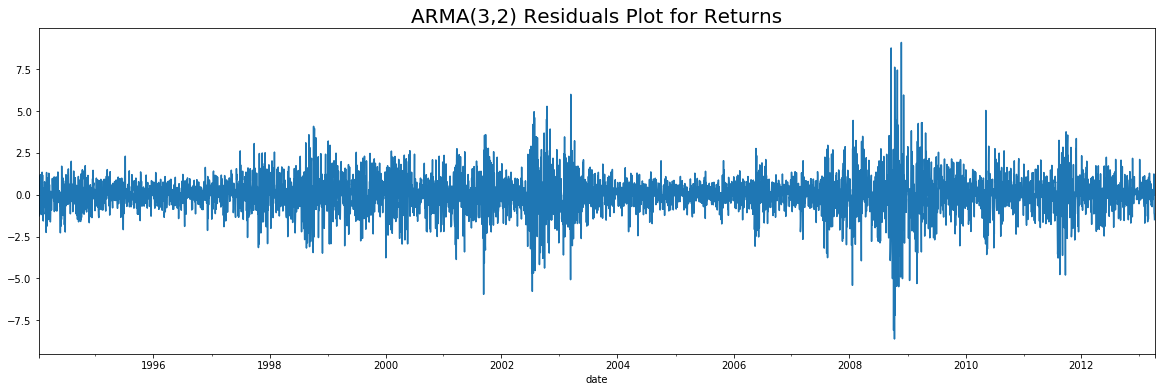

In [61]:
#plot of residual
train.resid_ret_ar3_ma2.plot(figsize=(20,6))
plt.title('ARMA(3,2) Residuals Plot for Returns', size=20)
plt.show()

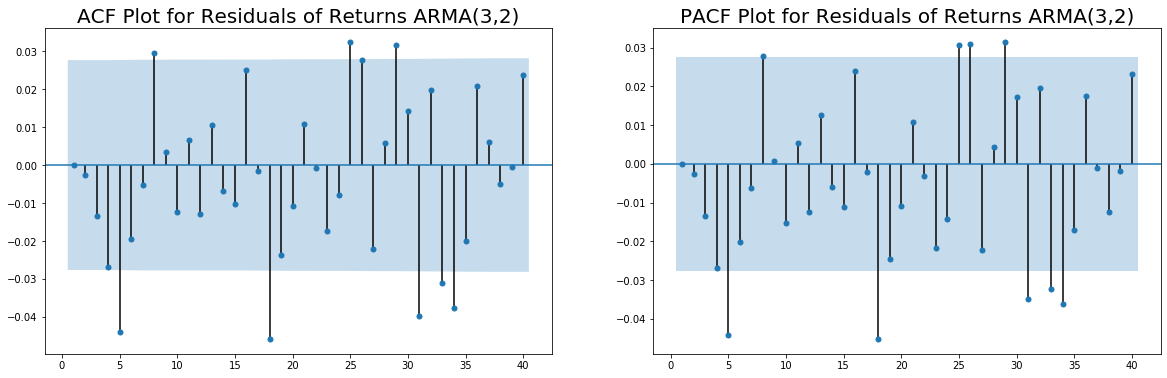

In [62]:
ACF_and_PACF(train.resid_ret_ar3_ma2[1:], 'Residuals of Returns ARMA(3,2)')

Residuals plot show the volatility of returns may not be fully comprehendable by just ARMA models. Note in the ACF, we have more significant lags unaccounted for because the 5th lag that was accounted for in just AR and just MA models is not in our ARMA(3,2) model. To remedy this, we will create models of the following form and compare them to see which one is the best fit.
- ARMA(5,5), ARMA(P,5), and ARMA(5,Q)

In [63]:
#ARMA(5,5)
model_ret_ar5_ma5= ARMA(train.returns[1:], order=(5,5))
model_ret_ar5_ma5.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(5, 5)   Log Likelihood               -7882.160
Method:                       css-mle   S.D. of innovations              1.163
Date:                Thu, 09 Apr 2020   AIC                          15788.321
Time:                        14:10:53   BIC                          15866.575
Sample:                    01-10-1994   HQIC                         15815.742
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.402      0.161      -0.008       0.045
ar.L1.returns    -0.0684      0.140     -0.490      0.624      -0.342       0.205
ar.L2.returns    -0.6722      0.146     -4.603      0.000      -0.958      -0.386
ar.L3.returns    -0.1152      0.141     -0.817      0.414      -0.392       0.161
ar.L4.returns     0.1779      0.129      1.381      0.167      -0.075       0.430
ar.L5.returns     0.1215      0.107      1.132      0.258      -0.089       0.332
ma.L1.returns     0.0443      0.138      0.322      0.748      -0.226       0.314
ma.L2.returns     0.6223      0.144      4.321      0.000       0.340       0.905
ma.L3.returns     0.0107      0.136      0.079      0.937      -0.256       0.277
ma.L4.returns    -0.1753      0.122     -1.436      0.151      -0.415       0.064
ma.L5.returns    -0.2240      0.104     -2.148      0.032      -0.428      -0.020
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0870           -1.0364j            1.0401           -0.2367
AR.2            0.0870           +1.0364j            1.0401            0.2367
AR.3            1.7715           -0.0000j            1.7715           -0.0000
AR.4           -1.7050           -1.1784j            2.0726           -0.4038
AR.5           -1.7050           +1.1784j            2.0726            0.4038
MA.1            0.1033           -1.0434j            1.0485           -0.2343
MA.2            0.1033           +1.0434j            1.0485            0.2343
MA.3            1.4855           -0.0000j            1.4855           -0.0000
MA.4           -1.2373           -1.0965j            1.6532           -0.3846
MA.5           -1.2373           +1.0965j            1.6532            0.3846
-----------------------------------------------------------------------------
"""

The model above has a lot of insignificant coefficients. Taking both returns and residuals from five years ago is therefore redundant, so we should have a model that is either ARMA(P,5) or ARMA(5,Q) for best results. The options and their test results (if you do this exercise) are:
- **ARMA(1,5) and ARMA(5,1) -> all significant coefficients**
- ARMA(2,5) and ARMA(5,2) -> some insignificant coefficients
- ARMA(3,5) and ARMA(5,3) -> some insignificant coefficients
- ARMA(4,5) and ARMA(5,4) -> some insignificant coefficients

Because the two viable models above have the same degrees of freedom, we cannot use the LLR test to compare them so we use the no nested test (higher LL and lower AIC wins)

In [64]:
lower = ARMA(train.returns[1:], order=(1,5))
higher = ARMA(train.returns[1:], order=(5,1))
LLR_ARMA_Nonest(lower, higher)

Higher Order Model Measures:
LL = -7889.31128294585 	AIC = 15794.6225658917
Lower Order Model Measures:
LL = -7890.973460209439 	AIC = 15797.946920418877
**Higher order model > Lower order model**


ARMA(5,1) > ARMA(1,5) so now we move forward with this and compare it to our original choice for the best model ARMA(3,2)

In [65]:
LLR_ARMA_Nonest(model_ret_ar3_ma2, higher)

Higher Order Model Measures:
LL = -7889.31128294585 	AIC = 15794.6225658917
Lower Order Model Measures:
LL = -7895.747458514556 	AIC = 15805.494917029111
**Higher order model > Lower order model**


New optimal model is identified as ARMA(5,1) from above. This means even when we pick an optimal model, we should always examine the residuals and its correlogram to see if we missed a higher order model that is more optimal. Now we look at the residuals for the ARMA(5,1) model again

In [66]:
train['resid_ret_ar5_ma1'] = higher.fit().resid

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


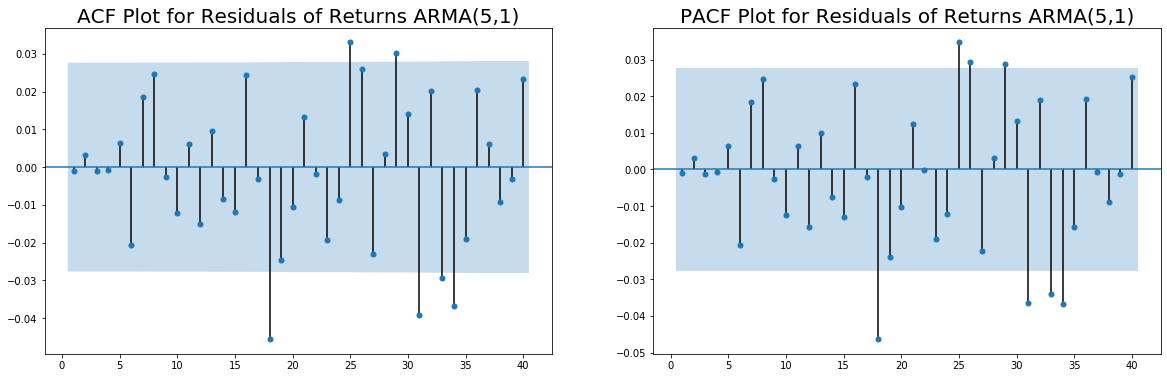

In [67]:
ACF_and_PACF(train.resid_ret_ar5_ma1[1:], 'Residuals of Returns ARMA(5,1)')

Since more than ten of the initial lags are not significant, we have random values which is what we were trying to achieve in an optimal model.

## ARMA Models - Non stationary Data (Prices)
Recall, on their own AR and MA models dont have good results with non-stationary data. Let's try with ARMA based on the correlograms below. First with simple model

### Simple ARMA(1,1) Model

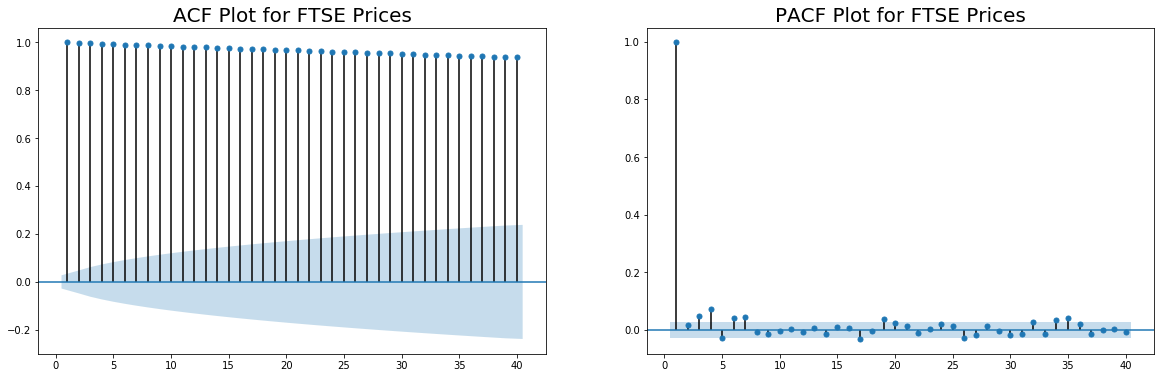

In [69]:
ACF_and_PACF(train.market_value, 'FTSE Prices')

In [71]:
### Simple ARMA(1,1) Model
model_ar1_ma1 = ARMA(train.market_value, order=(1,1))
model_ar1_ma1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(1, 1)   Log Likelihood              -27621.789
Method:                       css-mle   S.D. of innovations             59.248
Date:                Thu, 09 Apr 2020   AIC                          55251.579
Time:                        14:31:17   BIC                          55277.664
Sample:                    01-07-1994   HQIC                         55260.719
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6411    496.778     10.245      0.000    4115.974    6063.309
ar.L1.market_value     0.9985      0.001   1323.192      0.000       0.997       1.000
ma.L1.market_value    -0.0190      0.015     -1.274      0.203      -0.048       0.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
MA.1           52.5192           +0.0000j           52.5192            0.0000
-----------------------------------------------------------------------------
"""

### Higher Order ARMA Model
Simple model is not the best fit because the MA component is not significant. We look at the residuals ACF to see what we missed in terms of number of lags

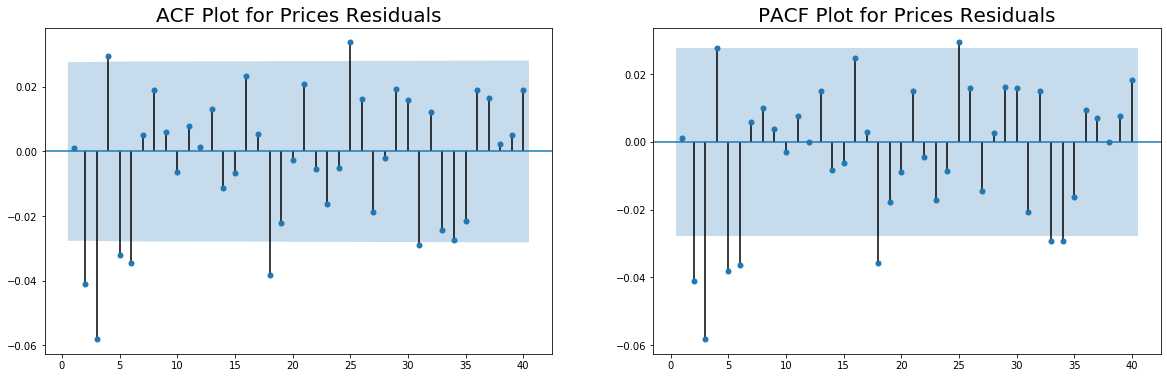

In [72]:
ACF_and_PACF(model_ar1_ma1.fit().resid, 'Prices Residuals')

First five lags are significant so we add five more lags to our model

In [73]:
model_ar6_ma6 = ARMA(train.market_value, order=(6,6))
model_ar6_ma6.fit().summary()

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

We are given three options to fix our error above:
- Make data stationary = we already did this when modeling returns and also we want an order of 6 so we won't do this
- Choose a different model order = we want to avoid this as well because we know from the residuals ACF that the order of 6 is good to start with
- Pass your own start params = this sets the initial values to fit the model. We need to pass integers greater than the AR order of the model. If the value fails we keep increasing it until the model doesnt fail.

For this model, we need to use 11 AR lags to start.

In [79]:
model_ar6_ma6 = ARMA(train.market_value, order=(6,6))
model_ar6_ma6.fit(start_ar_lags=11).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(6, 6)   Log Likelihood              -27587.932
Method:                       css-mle   S.D. of innovations             58.849
Date:                Thu, 09 Apr 2020   AIC                          55203.864
Time:                        14:39:30   BIC                          55295.164
Sample:                    01-07-1994   HQIC                         55235.856
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6496    568.255      8.957      0.000    3975.890    6203.409
ar.L1.market_value     1.9275      0.032     59.898      0.000       1.864       1.991
ar.L2.market_value    -1.7359      0.040    -43.365      0.000      -1.814      -1.657
ar.L3.market_value     1.2677      0.034     36.794      0.000       1.200       1.335
ar.L4.market_value    -0.2375      0.157     -1.514      0.130      -0.545       0.070
ar.L5.market_value    -0.4061      0.164     -2.475      0.013      -0.728      -0.085
ar.L6.market_value     0.1839      0.049      3.767      0.000       0.088       0.280
ma.L1.market_value    -0.9486      0.035    -27.029      0.000      -1.017      -0.880
ma.L2.market_value     0.7800      0.032     24.187      0.000       0.717       0.843
ma.L3.market_value    -0.5084      0.031    -16.321      0.000      -0.569      -0.447
ma.L4.market_value    -0.1561      0.158     -0.991      0.322      -0.465       0.153
ma.L5.market_value     0.0952      0.057      1.679      0.093      -0.016       0.206
ma.L6.market_value     0.0670      0.024      2.814      0.005       0.020       0.114
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0857           -1.0502j            1.0537           -0.2370
AR.2            0.0857           +1.0502j            1.0537            0.2370
AR.3           -2.0258           -0.0000j            2.0258           -0.5000
AR.4            1.0011           -0.0000j            1.0011           -0.0000
AR.5            1.5307           -0.2674j            1.5539           -0.0275
AR.6            1.5307           +0.2674j            1.5539            0.0275
MA.1            0.1028           -1.0612j            1.0662           -0.2346
MA.2            0.1028           +1.0612j            1.0662            0.2346
MA.3            1.3624           -0.2797j            1.3908           -0.0322
MA.4            1.3624           +0.2797j            1.3908            0.0322
MA.5           -2.1755           -1.4339j            2.6055           -0.4073
MA.6           -2.1755           +1.4339j            2.6055            0.4073
-----------------------------------------------------------------------------
"""

Note again that not all coefficients are significant at 5% which means looking at 6 AR and MA lags is redundant > we need to use either ARMA(P,6) or ARMA(6,Q). **If you test everything that fits this description, the only viable ones are ARMA(5,6) and ARMA(6,1)**. We then compare their log likelihoods and information criteria because there is no nested model here

In [83]:
model_ar5_ma6 = ARMA(train.market_value, order=(5,6))
model_ar6_ma1 = ARMA(train.market_value, order=(6,1))
LLR_ARMA_Nonest(model_ar5_ma6, model_ar6_ma1, lags=7)

Higher Order Model Measures:
LL = -27594.194571052347 	AIC = 55206.389142104694
Lower Order Model Measures:
LL = -27587.862948075737 	AIC = 55201.725896151474
Lower order model > Higher order model


**Optimal model is ARMA(5,6) > ARMA(6,1)** so we now move on to the residuals to see if we need to examine other models and have a new optimal.

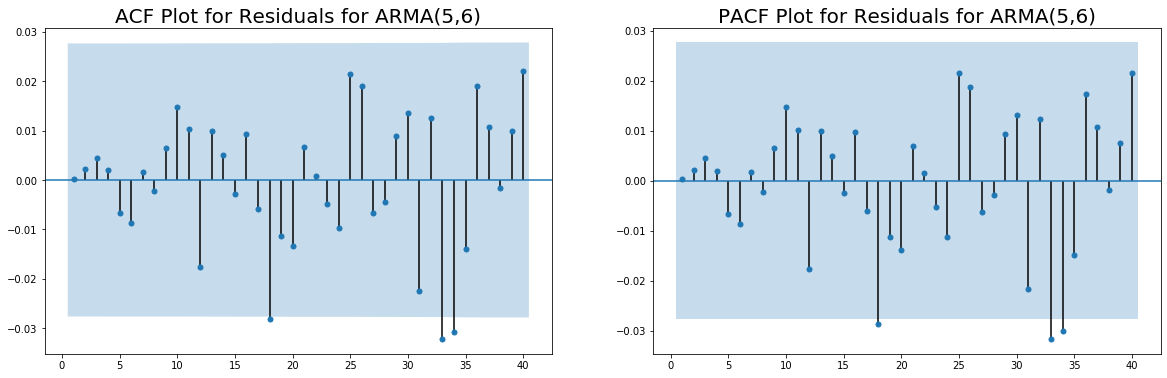

In [85]:
ACF_and_PACF(model_ar5_ma6.fit(start_ar_lags=7).resid, 'Residuals for ARMA(5,6)')

**ACF Review:** Most of the lag coefficients are insignificant and resemble white noise so we are going forward with our optimal model of ARMA(5,6). However, recall we made a statement that ARMA models do not perform well with non-stationary data. To see if our note is right, lets compare the ARMA(5,1) for modeling returns (a stationary series) to this ARMA(5,6) modeling prices which are non stationary.

In [86]:
model_ret_ar5_ma1 = ARMA(train.returns[1:], order=(5,1))
res_ret_ar5_ma1 = model_ret_ar5_ma1.fit()
res_ar5_ma6 = model_ar5_ma6.fit(start_ar_lags=7)

print('ARMA(5,1) LL=', res_ret_ar5_ma1.llf, '\tAIC =', res_ret_ar5_ma1.aic)
print('ARMA(5,6) LL=', res_ar5_ma6.llf, '\tAIC =', res_ar5_ma6.aic)

ARMA(5,1) LL= -7889.31128294585 	AIC = 15794.6225658917
ARMA(5,6) LL= -27587.862948075737 	AIC = 55201.725896151474


The returns model performs much better than the price model (much higher LL and much lower information criteria requested). Now let's see how to adjust ARMA models to make them better predictors for non-stationary data.

### Adjusting ARMA Models for Non-stationary Data
We use ARIMA models instead!!
It accounts for non-seasonal differences in the data that we need to examine to establish stationarity in the data. 
I = Integrated. That means the number of times you difference the series to make it stationary.